In [ ]:
# Code optimised by Gemini 2.5Pro

# Environment and Load Dataset

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tarfile
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
ds, ds_info = tfds.load('stanford_dogs', split=['train[:25%]', 'test[:25%]'], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.A8RO0P_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.A8RO0P_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


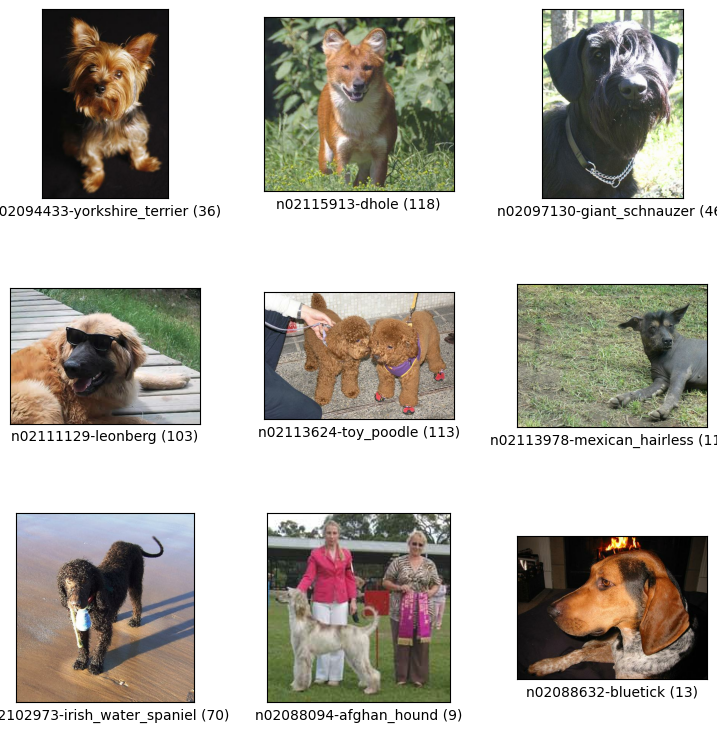

In [ ]:
# Train-Vali split
train_dataset = ds[0]
validation_dataset = ds[1]

fig = tfds.show_examples(train_dataset, ds_info)

In [ ]:
CLASS_SIZE = 120
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

In [ ]:
# Create dataset from images
train_dataset = train_dataset.map(lambda image, label: (
    tf.image.resize(tf.cast(image, tf.float32), (IMG_SIZE[0], IMG_SIZE[1])),
    label
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


validation_dataset = validation_dataset.map(lambda image, label: (
    tf.image.resize(tf.cast(image, tf.float32), (IMG_SIZE[0], IMG_SIZE[1])),
    label
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of train batches: 188
Number of validation batches: 135


# Data augmentation

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    # random mirror
    tf.keras.layers.RandomFlip("horizontal"),

    # random scaled cropping with scale and aspect variations
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.3),
                               width_factor=(-0.2, 0.3),
                               fill_mode='reflect'),

    # color jittering
    tf.keras.layers.RandomBrightness(factor=0.1),     # ±10%
    tf.keras.layers.RandomContrast(factor=0.1)       # ±10%
])

# Load Base Model

In [ ]:
# Rescale pixels with ResNet101V2
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
# Build base model ResNet101V2
base_model = tf.keras.applications.ResNet101V2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet' # use pre-trained
)

In [ ]:
# Take one batch of data (images and labels) from the training dataset
image_batch, label_batch = next(iter(train_dataset))

# Pass the image batch through the base model to extract features
feature_batch = base_model(image_batch)

# Print the shape of the extracted feature tensor
print(feature_batch.shape)

(16, 7, 7, 2048)


# Training Classification Head

In [ ]:
# freeze the convolutional base
base_model.trainable = False

In [ ]:
# Build classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [ ]:
# Build output layer
prediction_layer = tf.keras.layers.Dense(CLASS_SIZE, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 120)


In [ ]:
# Build input layer
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = data_augmentation(inputs)
x = preprocess_input(x)   # rescale pixels
x = base_model(x, training=False)
x = global_average_layer(x)

x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101v2 (Functional)        │ (None, 7, 7, 2048)     │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │       245,880 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,872,440 (163.55 MB)

 Trainable params: 245,880 (960.47 KB)

 Non-trainable params: 42,626,560 (162.61 MB)

In [ ]:
# Use hyperparameters from paper
eta = 0.001      # learning rate [0.01, 0.001]
lam = 0.0001    # weight decay
mu = 0.9        # momentum [0.0, 0.9]

# No. of epoch
epochs = 10

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=eta, momentum=mu, weight_decay=lam),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

print(f"momentum {mu}, learning rate {eta}")
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

momentum 0.9, learning rate 0.001
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 4.4088 - sparse_categorical_accuracy: 0.1431 - val_loss: 1.5424 - val_sparse_categorical_accuracy: 0.5953
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 1.4410 - sparse_categorical_accuracy: 0.6208 - val_loss: 1.1102 - val_sparse_categorical_accuracy: 0.6904
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 1.0172 - sparse_categorical_accuracy: 0.7053 - val_loss: 0.9657 - val_sparse_categorical_accuracy: 0.7245
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.8432 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.7338
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.7411 - sparse_categorical_accuracy: 0.7773 - val_loss: 0.8861 - val_sparse_categorical_accuracy: 0.7343
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.6629 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.8887 - val

# Continue with Hyperparameter Tuning

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=eta, momentum=mu, weight_decay=lam),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Continue training from previous epoch
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

In [ ]:
print(f"momentum {mu}, learning rate {eta}")
history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=len(history.epoch), validation_data=validation_dataset)

momentum 0.9, learning rate 0.001
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - loss: 1.6128 - sparse_categorical_accuracy: 0.6402 - val_loss: 1.2536 - val_sparse_categorical_accuracy: 0.6392
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 0.7174 - sparse_categorical_accuracy: 0.8344 - val_loss: 1.1800 - val_sparse_categorical_accuracy: 0.6573
Epoch 13/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 0.3407 - sparse_categorical_accuracy: 0.9427 - val_loss: 1.1814 - val_sparse_categorical_accuracy: 0.6690
Epoch 14/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 0.2082 - sparse_categorical_accuracy: 0.9644 - val_loss: 1.1876 - val_sparse_categorical_accuracy: 0.6709
Epoch 15/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9862 - val_loss: 1.1545 - val_sparse_categorical_accuracy: 0.6872
Epoch 16/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 0.0825 - sparse_categorical_accuracy: 0.9926 - val_loss: 

# Make Graphs

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

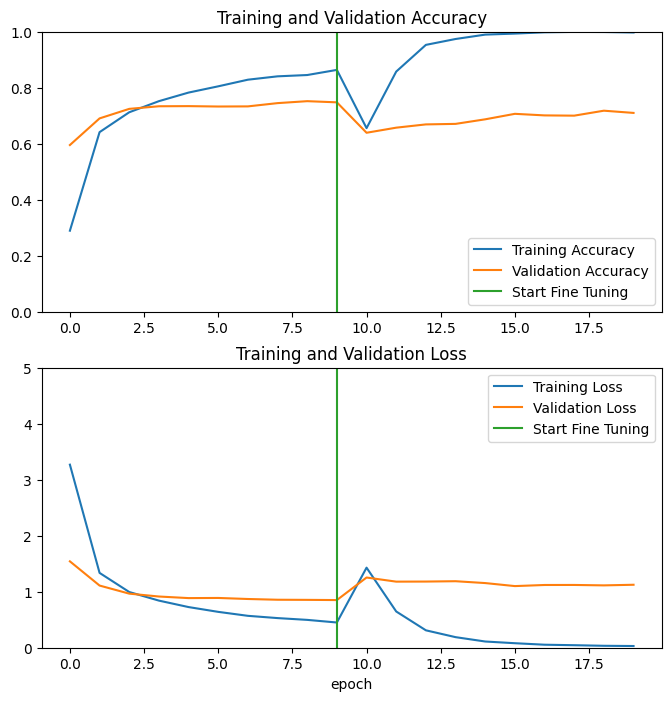

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()